In [43]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 23 2018

@author: cesarechavarria
"""
import matplotlib
#matplotlib.use('Agg')
import cv2
import os
import sys
import optparse
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc,interpolate,stats,signal, spatial, ndimage
import json
import re
import pylab as pl
import seaborn as sns
import pandas as pd
import h5py
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ==================================== miscellaneous functions ========================================
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
def load_obj(name):
    with open(name, 'r') as r:
        fileinfo = json.load(r)
    return fileinfo
    
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def save_obj(obj, name ):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# ==================================== MAIN FUNCTIONS ========================================        

def block_mean(im0, fact):
    #function to block-downsample an image by a given factor
    
    im1 = cv2.boxFilter(im0,0, (fact, fact), normalize = 1)
    im2 = cv2.resize(im1,None,fx=1.0/fact, fy=1.0/fact, interpolation = cv2.INTER_CUBIC)
    return im2
    
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy/fact * (X/fact) + Y/fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx/fact, sy/fact)
    return res


def get_frame_rate(relevant_dir):
    #get frame rate
    
    # READ IN FRAME TIMES FILE
    pfile=open(os.path.join(relevant_dir,'performance.txt'))

    #READ HEADERS AND FIND RELEVANT COLUMNS
    headers=pfile.readline()
    headers=headers.split()

    count = 0
    while count < len(headers):
        if headers[count]=='frame_rate':
            rate_idx=count
            break
        count = count + 1

    #read just first line
    for line in pfile:
        x=line.split()
        frame_rate = x[rate_idx]
        break
    pfile.close()
    return float(frame_rate)

def get_frame_attribute(relevant_dir,attr_string):
    #get frame-by-frame details
    
    # READ IN FRAME TIMES FILE
    pfile=open(os.path.join(relevant_dir,'frame_times.txt'))

    #READ HEADERS AND FIND RELEVANT COLUMNS
    headers=pfile.readline()
    headers=headers.split()

    count = 0
    while count < len(headers):
        if headers[count]== attr_string:
            sync_idx=count
            break
        count = count + 1

    frame_attr=[]
    # GET DESIRED DATA
    for line in pfile:
        x=line.split()
        frame_attr.append(x[sync_idx])

    frame_attr=np.array(map(float,frame_attr))
    pfile.close()

    return frame_attr


def get_feature_info(process_img, box_pt1, box_pt2, feature_thresh, target_feature='pupil',criterion='area'):
    #get feature info for pupil or corneal reflection
    
    #get grayscale
    if process_img.ndim>2:
        process_img=np.mean(process_img,2)
    #apply restriction box 
    process_img = process_img[box_pt1[1]:box_pt2[1],box_pt1[0]:box_pt2[0]]

    #threshold
    img_roi = np.zeros(process_img.shape)
    if target_feature == 'pupil':
        thresh_array =process_img<feature_thresh
    else:
        thresh_array =process_img>feature_thresh
    if np.sum(thresh_array)>0:#continue if some points have passed threshold
        if criterion == 'area':
            #look for largest area
            labeled, nr_objects = ndimage.label(thresh_array) 
            pix_area = np.zeros((nr_objects,))
            for i in range(nr_objects):
                pix_area[i] = len(np.where(labeled==i+1)[0])
            img_roi[labeled == (np.argmax(pix_area)+1)]=255
            img_roi = img_roi.astype('uint8')
        else:
            #look for region closes to center of box
            x = np.linspace(-1, 1, process_img.shape[1])
            y = np.linspace(-1, 1, process_img.shape[0])
            xv, yv = np.meshgrid(x, y)

            [radius,theta]=cart2pol(xv,yv)

            img_roi = np.zeros(process_img.shape)
            labeled, nr_objects = ndimage.label(thresh_array) 
            pix_distance = np.zeros((nr_objects,))
            for i in range(nr_objects):
                pix_distance[i] = np.min((labeled==i+1)*radius)
            img_roi[labeled == (np.argmin(pix_distance)+1)]=255
            img_roi = img_roi.astype('uint8')

        #get contours
        tmp, contours, hierarchy = cv2.findContours(img_roi,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        #find contour with most points
        pt_array =np.zeros((len(contours),))
        for count,cnt in enumerate(contours):
            pt_array[count] = len(cnt)
        if len(contours)>0 and np.max(pt_array)>=5:#otherwise ellipse fit will fail
            elp_idx = np.argmax(pt_array)

            #fit ellipse
            elp = cv2.fitEllipse(contours[elp_idx])

            #unpack values
            elp_center = tuple((elp[0][0]+box_pt1[0], elp[0][1]+box_pt1[1]))
            elp_axes = elp[1]
            elp_orientation = elp[2]
            return elp_center, elp_axes, elp_orientation
        else:
            return tuple((0,0)), tuple((0,0)), 0
    else:
        return tuple((0,0)), tuple((0,0)), 0
 

def get_interp_ind(idx, interp_sites, step):
    redo = 0
    interp_idx = idx + step
    if interp_idx in interp_sites:
        redo = 1
    while redo:
        redo = 0
        interp_idx = interp_idx + step
        if interp_idx in interp_sites:
            redo = 1
    return interp_idx
         
def interpolate_sites(var_array, interp_sites):
    array_interp = np.copy(var_array)
    for target_idx in interp_sites:
        if target_idx < var_array.size:
            ind_pre = get_interp_ind(target_idx, interp_sites, -1)
            ind_post = get_interp_ind(target_idx, interp_sites, 1)
        
            x_good = np.array([ind_pre,ind_post])
            y_good = np.hstack((var_array[ind_pre],var_array[ind_post]))
            interpF = interpolate.interp1d(x_good, y_good,1)
            new_value=interpF(target_idx)
        else:
            new_value = var_array[target_idx-1]
       

        array_interp[target_idx]=new_value
    return array_interp

def process_signal(var_array, interp_flag, filt_kernel=11):
    #Clean up singal by interpolating the odd missing values and median filtering
    
    #get sites to interpolate
    interp_list1 = np.where(var_array == 0)[0]
    interp_list2 = np.where(interp_flag== 1)[0]
    interp_sites = np.concatenate((interp_list1,interp_list2))
    interp_sites = np.unique(interp_sites)
    
    #get interpolated list
    var_interp = interpolate_sites(var_array, interp_sites)
    
    #do some medial filtering
    nice_array = signal.medfilt(var_interp, filt_kernel)
    return nice_array

def plot_whole_timecourse(tstamps,value,stim_on_times,label,filename):
    
    #figure formatting
    sns.set_style("white")
    sns.set_context("paper",font_scale = 2.5)
    fig,ax=plt.subplots(figsize = (24, 6))

    #mark stimulus onset times
    for f in stim_on_times:
        ax.axvline(x=f, linewidth=1, color='k',alpha = 0.2, linestyle = '--')
        
    
    #plot variable of interest along with blink events
    ax.plot(tstamps,value)
    ymin,ymax = ax.get_ylim()

    if len(blink_times)>0:
                ax.plot(blink_times, np.ones((len(blink_times),))*(ymax+1),'m*')
            
    # Label axes
    ax.set_xlabel('Time (secs)',fontsize = 18,weight = 'bold')
    ax.set_ylabel('%s'%(label),fontsize = 18,weight = 'bold')


    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax)
    
    # Save figure
    fig.savefig(filename,dpi = 300)
    plt.close()

    

In [111]:
source_dir = '../sample_data'
make_movie = True
space_filt_size = 5
time_filt_size = 11

In [112]:
#Get relevant directories an files
im_dir = os.path.join(source_dir,'frames')
times_dir = os.path.join(source_dir,'times')

#stimulus presentation time
para_file =  [f for f in os.listdir(times_dir) if f.endswith('.json')][0]#assuming a single file for all tiffs in run


#get relevant image list
im_list = [name for name in os.listdir(im_dir) if os.path.isfile(os.path.join(im_dir, name))]
sort_nicely(im_list)
im0 = cv2.imread(os.path.join(im_dir,im_list[0]))

#load user-specificed restriciton box
user_rect = load_obj(os.path.join(source_dir,'user_restriction_box.json'))


In [113]:
#make output directories
output_dir = '../sample_output'

output_file_dir = os.path.join(output_dir,'files')
if not os.path.exists(output_file_dir):
    os.makedirs(output_file_dir)
    
output_plot_dir = os.path.join(output_dir,'plots/complete')
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)

if make_movie:
    
    output_mov_dir = os.path.join(output_dir,'movie')
    if not os.path.exists(output_mov_dir):
        os.makedirs(output_mov_dir)

    tmp_dir = os.path.join(output_mov_dir, 'tmp')
    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir)
    os.makedirs(tmp_dir)

In [114]:
if 'pupil' in user_rect:
    
    #unpack values
    pupil_x1_orig = int(min([user_rect['pupil'][0][0],user_rect['pupil'][1][0]]))
    pupil_x2_orig = int(max([user_rect['pupil'][0][0],user_rect['pupil'][1][0]]))
    pupil_y1_orig = int(min([user_rect['pupil'][0][1],user_rect['pupil'][1][1]]))
    pupil_y2_orig = int(max([user_rect['pupil'][0][1],user_rect['pupil'][1][1]])) 

    pupil_x1 = pupil_x1_orig
    pupil_y1 = pupil_y1_orig
    pupil_x2 = pupil_x2_orig
    pupil_y2 = pupil_y2_orig

    #use user-defined-threshold otherwise use-average pixel value within user-defined box
    if 'pupil_thresh' in user_rect:
        pupil_thresh = int(user_rect['pupil_thresh'])
    else:
        pupil_thresh = np.mean(im0[pupil_y1:pupil_y2,pupil_x1:pupil_x2])
    print 'threshold value for pupil: %10.4f'%(pupil_thresh)

if 'cr' in user_rect:
    
    #unpack values
    cr_x1_orig = int(min([user_rect['cr'][0][0],user_rect['cr'][1][0]]))
    cr_x2_orig = int(max([user_rect['cr'][0][0],user_rect['cr'][1][0]]))
    cr_y1_orig = int(min([user_rect['cr'][0][1],user_rect['cr'][1][1]]))
    cr_y2_orig = int(max([user_rect['cr'][0][1],user_rect['cr'][1][1]])) 

    cr_x1 = cr_x1_orig
    cr_y1 = cr_y1_orig
    cr_x2 = cr_x2_orig
    cr_y2 = cr_y2_orig
    
    #use user-defined-threshold otherwise use-average pixel value within user-defined box
    if 'cr_thresh' in user_rect:
        cr_thresh = int(user_rect['cr_thresh'])
    else:
        cr_thresh = np.mean(im0[cr_y1:cr_y2,cr_x1:cr_x2])
        
    print 'threshold value for corneal reflection: %10.4f'%(cr_thresh)

#make empty arrays. 
#keeping track of center, length of axes, orientation, and missing value flag for pupil and corneal reflection
if 'pupil' in user_rect:
    pupil_center_list = np.zeros((len(im_list),2))
    pupil_axes_list = np.zeros((len(im_list),2))
    pupil_orientation_list = np.zeros((len(im_list),))
    pupil_flag_event = np.zeros((len(im_list),))
if 'cr' in user_rect:
    cr_center_list = np.zeros((len(im_list),2))
    cr_axes_list = np.zeros((len(im_list),2))
    cr_orientation_list = np.zeros((len(im_list),))
    cr_flag_event = np.zeros((len(im_list),))

threshold value for pupil:    27.0000
threshold value for corneal reflection:   104.0000


In [115]:

for im_count in range(len(im_list)):
    #display count
    if im_count%1000==0:
        print 'Processing Image %d of %d....' %(im_count,len(im_list))

    #load image
    im0 = cv2.imread(os.path.join(im_dir,im_list[im_count]))
    im_disp = np.copy(im0)#save for drawing on, later
    
    if space_filt_size is not None:
        #smooth image
        im0= cv2.boxFilter(im0,0, (space_filt_size, space_filt_size), normalize = 1)

    if 'pupil' in user_rect:
        #get features
        pupil_center, pupil_axes, pupil_orientation = get_feature_info(im0, (pupil_x1,pupil_y1), (pupil_x2,pupil_y2),\
                                                                       pupil_thresh, 'pupil')

        pupil_ratio = np.true_divide(pupil_axes[0],pupil_axes[1])
        
        if pupil_center[0]==0 or pupil_ratio <=.6 or pupil_ratio>(1.0/.6):#flag this frame, probably blinking
            pupil_flag_event[im_count] = 1


        #draw and save to file
        ellipse_params = tuple((pupil_center,pupil_axes,pupil_orientation))
        if make_movie:
            cv2.rectangle(im_disp,(pupil_x1,pupil_y1),(pupil_x2,pupil_y2),(0,255,255),1)
            if pupil_flag_event[im_count] == 0:
                cv2.ellipse(im_disp, ellipse_params,(0,0,255),1)
            else:
                cv2.ellipse(im_disp, ellipse_params,(0,255,0),1)
           
            
        if pupil_flag_event[im_count] == 0:#not blinking
             #Re-fit bounding box with some extra room
            dummy_img = np.zeros(im0.shape)
            cv2.ellipse(dummy_img, ellipse_params,255,-1)
            dummy_img = np.mean(dummy_img,2)
            tmp, contours, hierarchy = cv2.findContours(dummy_img.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            x,y,w,h = cv2.boundingRect(contours[0])
            pupil_x1 = int(x-3)
            pupil_y1 = int(y-3)
            pupil_x2 = int(x+w+3)
            pupil_y2 = int(y+h+3)

            #save to array
            pupil_center_list[im_count,:] = pupil_center
            pupil_axes_list[im_count,:] = pupil_axes
            pupil_orientation_list[im_count] = pupil_orientation

        #use original user-provided bouding box if we have multiple timepoints with inability to fit ellipses
        if im_count >10:
            if sum(pupil_flag_event[im_count-10:im_count])>= 5:
                #back to beginning with latest size
                pupil_x1 = int(pupil_x1_orig-10)
                pupil_y1 = int(pupil_y1_orig-10)
                pupil_x2 = int(pupil_x2_orig+10)
                pupil_y2 = int(pupil_y2_orig+10)

            else:
                #give yourself room for error after event
                if pupil_flag_event[im_count-1]<1:
                    pupil_x1 = int(pupil_x1-5)
                    pupil_y1 = int(pupil_y1-5)
                    pupil_x2 = int(pupil_x2+5)
                    pupil_y2 = int(pupil_y2+5)
                    
    if 'cr' in user_rect:#get features 
        #get features
        cr_center, cr_axes, cr_orientation = get_feature_info(im0, (cr_x1,cr_y1), (cr_x2,cr_y2),\
                                                                       cr_thresh, 'cr')

        cr_ratio = np.true_divide(cr_axes[0],cr_axes[1])
        cr_radius = np.mean(cr_axes)
        if cr_center[0]==0 or cr_radius>=20:#flag this frame, probably blinking
            cr_flag_event[im_count] = 1

        #draw and save to file
        ellipse_params = tuple((cr_center,cr_axes,cr_orientation))
        if make_movie:
            cv2.rectangle(im_disp,(cr_x1,cr_y1),(cr_x2,cr_y2),(255,255,0),1)
            if cr_flag_event[im_count] == 0:
                cv2.ellipse(im_disp, ellipse_params,(255,0,0),1)
            else:
                cv2.ellipse(im_disp, ellipse_params,(0,255,0),1)

        if cr_flag_event[im_count] == 0: #Re-fit bounding box with some extra room
            #Re-fit bounding box with some extra room
            dummy_img = np.zeros(im0.shape)
            cv2.ellipse(dummy_img, ellipse_params,255,-1)
            dummy_img = np.mean(dummy_img,2)
            tmp, contours, hierarchy = cv2.findContours(dummy_img.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            x,y,w,h = cv2.boundingRect(contours[0])
            cr_x1 = int(x-2)
            cr_y1 = int(y-2)
            cr_x2 = int(x+w+2)
            cr_y2 = int(y+h+2)

            #save to array
            cr_center_list[im_count,:] = cr_center
            cr_axes_list[im_count,:] = cr_axes
            cr_orientation_list[im_count] = cr_orientation
            
        #use original user-provided bouding box if we have multiple timepoints with inability to fit ellipses
        if im_count >10:    
            if sum(cr_flag_event[im_count-10:im_count])>= 5:
                #back to beginning with latest size
                cr_x1 = int(cr_x1_orig-4)
                cr_y1 = int(cr_y1_orig-4)
                cr_x2 = int(cr_x2_orig+4)
                cr_y2 = int(cr_y2_orig+4)


            else:
                #give yourself room for error after event
                if cr_flag_event[im_count-1]<1:
                    cr_x1 = int(cr_x1-2)
                    cr_y1 = int(cr_y1-2)
                    cr_x2 = int(cr_x2+2)
                    cr_y2 = int(cr_y2+2)

    if make_movie:
        cv2.imwrite((os.path.join(tmp_dir,im_list[im_count])), im_disp)

Processing Image 0 of 18077....
Processing Image 1000 of 18077....
Processing Image 2000 of 18077....
Processing Image 3000 of 18077....
Processing Image 4000 of 18077....
Processing Image 5000 of 18077....
Processing Image 6000 of 18077....
Processing Image 7000 of 18077....
Processing Image 8000 of 18077....
Processing Image 9000 of 18077....
Processing Image 10000 of 18077....
Processing Image 11000 of 18077....
Processing Image 12000 of 18077....
Processing Image 13000 of 18077....
Processing Image 14000 of 18077....
Processing Image 15000 of 18077....
Processing Image 16000 of 18077....
Processing Image 17000 of 18077....
Processing Image 18000 of 18077....


In [116]:
frame_period*18000

900.0

In [64]:
frame_period

0.05

In [117]:
#***get camera timestamps****
frame_rate = get_frame_rate(times_dir)
frame_period = 1.0/frame_rate
frame_idx = get_frame_attribute(times_dir,'frame_number')
#assume a steady frame rate
camera_time = np.arange(0,frame_period*len(frame_idx),frame_period)
#correct for unmatched vector lengths
if camera_time.shape[0]>frame_idx.shape[0]:
    camera_time = np.delete(camera_time,-1)

if make_movie:#
    video_file = os.path.join(output_mov_dir,'annotated_movie')
    cmd = 'ffmpeg -y -r %10.4f -i %s/%s.png -vcodec libx264 -f mp4 -pix_fmt yuv420p %s.mp4'%(frame_rate,tmp_dir,'%d',video_file)
    os.system(cmd)

    shutil.rmtree(tmp_dir)

In [39]:
para_file

'parsed_trials.json'

In [118]:
#****get trial info times***
print 'Getting paradigm info from: %s'%(os.path.join(times_dir, para_file))
with open(os.path.join(times_dir, para_file), 'r') as f:
    trial_info = json.load(f)

stim_on_times = np.zeros((len(trial_info)))
stim_off_times = np.zeros((len(trial_info)))

for ntrial in range(len((trial_info))):
    trial_string = 'trial%05d'%(ntrial+1)
    stim_on_times[ntrial]=trial_info[trial_string]['stim_on_times']/(1E3*60)#convert to minutes
    stim_off_times[ntrial]=trial_info[trial_string]['stim_off_times']/(1E3*60)#convert to minutes

Getting paradigm info from: ../sample_data/times/parsed_trials.json


In [119]:
 #***get traces for relevant features**
print 'Processing traces for extracted features'
#blink times
if 'pupil' in user_rect and 'cr' in user_rect:
    blink_flag_event = np.logical_and(pupil_flag_event,cr_flag_event)
else:
    blink_flag_event = pupil_flag_event

blink_events = np.where(blink_flag_event==1)[0]#get indices of probable blink events    
if len(blink_events>0):
    blink_times = camera_time[blink_events]/60.0
else:
    blink_times = []

if 'pupil' in user_rect:
    pupil_events = np.where(pupil_flag_event==1)[0]#get indices of probable blink events    
    if len(pupil_events>0):
        pupil_flag_times = camera_time[pupil_events]/60.0
    else:
        pupil_flag_times = []
        
    #pixel radius
    tmp = np.mean(pupil_axes_list,1)#collapse across ellipse axes
    pupil_radius = process_signal(tmp, pupil_flag_event, time_filt_size)#clean up data a bit


    #pupil aspect ratio
    tmp = np.true_divide(pupil_axes_list[:,0],pupil_axes_list[:,1])#collapse across ellipse axes
    pupil_aspect = process_signal(tmp, pupil_flag_event, time_filt_size)#clean up data a bit

    #pupil orientation
    tmp = pupil_orientation_list[:]
    pupil_orientation = process_signal(tmp, pupil_flag_event, time_filt_size)#clean up data a bit

    # pupil position X 
    tmp = pupil_center_list[:,1].copy()
    pupil_pos_x = np.squeeze(process_signal(tmp, pupil_flag_event, time_filt_size))#clean up data a bit

    # pupil position Y
    tmp = pupil_center_list[:,0].copy()
    pupil_pos_y = np.squeeze(process_signal(tmp, pupil_flag_event, time_filt_size))#clean up data a bit

    #distance from first frame
    tmp_pos = np.transpose(np.vstack((pupil_pos_x,pupil_pos_y)))
    pupil_dist = np.squeeze(spatial.distance.cdist(tmp_pos,tmp_pos[0:1,:]))

if 'cr' in user_rect:
    cr_events = np.where(cr_flag_event==1)[0]#get indices of probable blink events    
    if len(cr_events>0):
        cr_flag_times = camera_time[cr_events]/60.0
    else:
        cr_flag_times = []
        
    #pixel radius
    tmp = np.mean(cr_axes_list,1)#collapse across ellipse axes
    cr_radius = process_signal(tmp, cr_flag_event, time_filt_size)#clean up data a bit


    #cr aspect ratio
    tmp = np.true_divide(cr_axes_list[:,0],cr_axes_list[:,1])#collapse across ellipse axes
    cr_aspect = process_signal(tmp, cr_flag_event, time_filt_size)#clean up data a bit

    #cr orientation
    tmp = cr_orientation_list[:]
    cr_orientation = process_signal(tmp, cr_flag_event, time_filt_size)#clean up data a bit

    # cr position X 
    tmp = cr_center_list[:,1].copy()
    cr_pos_x = np.squeeze(process_signal(tmp, cr_flag_event, time_filt_size))#clean up data a bit

    # cr position Y
    tmp = cr_center_list[:,0].copy()
    cr_pos_y = np.squeeze(process_signal(tmp, cr_flag_event, time_filt_size))#clean up data a bit

    #distance from 1st frame
    tmp_pos = np.transpose(np.vstack((cr_pos_x,cr_pos_y)))
    cr_dist = np.squeeze(spatial.distance.cdist(tmp_pos,tmp_pos[0:1,:]))

#use corneal reflection postion to correct pupil location
if 'pupil' in user_rect and 'cr' in user_rect:
    #relative pupil-position-x
    tmp = pupil_center_list[:,1]-cr_center_list[:,1]
    pupil_pos_x_rel = np.squeeze(process_signal(tmp, np.logical_or(pupil_flag_event,cr_flag_event), time_filt_size))#clean up data a bit

    tmp_y = pupil_center_list[:,0]-cr_center_list[:,0]
    pupil_pos_y_rel = np.squeeze(process_signal(tmp, np.logical_or(pupil_flag_event,cr_flag_event), time_filt_size))#clean up data a bit

    #pupil - distance- relative to CR
    tmp_pos = np.transpose(np.vstack((pupil_pos_x_rel,pupil_pos_y_rel)))
    pupil_dist_rel = np.squeeze(spatial.distance.cdist(tmp_pos,tmp_pos[0:1,:]))
    
    #pupil - motion - relative to CR
    tmp = np.diff(pupil_dist_rel)
    pupil_motion_rel = np.hstack((0,tmp))#pad with 0 to keep same size of array



Processing traces for extracted features


In [121]:
out_fn = os.path.join(output_plot_dir,'pupil_radius_vs_time.png')
plot_whole_timecourse(np.true_divide(camera_time,60),pupil_radius,stim_on_times,'Pupil Radius',out_fn)

out_fn = os.path.join(output_plot_dir,'pupil_position_vs_time.png')
plot_whole_timecourse(np.true_divide(camera_time,60),pupil_dist_rel,stim_on_times,'Pupil Position (Relative to CR)',out_fn)

out_fn = os.path.join(output_plot_dir,'pupil_motion_vs_time.png')
plot_whole_timecourse(np.true_divide(camera_time,60),pupil_motion_rel,stim_on_times,'Pupil Motion (Relative to CR)',out_fn)

In [ ]:
#plot

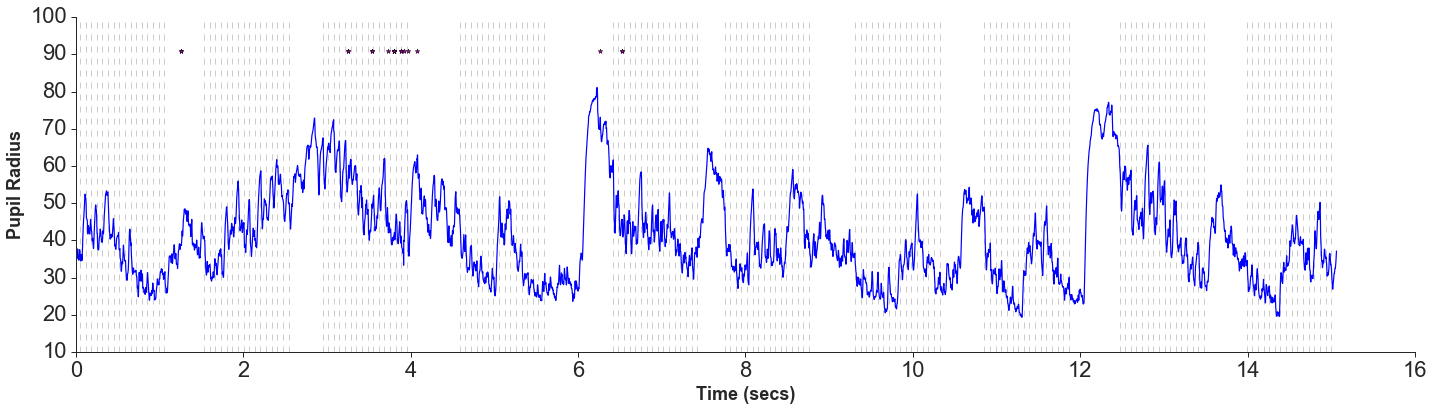

In [97]:
sns.set_style("white")
sns.set_context("paper",font_scale = 2.5)

fig,ax=plt.subplots(figsize = (24, 6))

for f in stim_on_times:
    ax.axvline(x=f, linewidth=1, color='k',alpha = 0.2, linestyle = '--')
tstamps = np.true_divide(camera_time,60)
ax.plot(tstamps,pupil_radius)

ax.set_xlabel('Time (secs)',fontsize = 18,weight = 'bold')
ax.set_ylabel('Pupil Radius',fontsize = 18,weight = 'bold')

ymin,ymax = ax.get_ylim()

if len(blink_times)>0:
            ax.plot(blink_times, np.ones((len(blink_times),))*(ymax+1),'m*')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

sns.despine(trim=True, offset=0, bottom=False, left=False, top = True, right = True,ax = ax)

In [122]:
#save to file
    
#**save complete traces**
output_fn = os.path.join(output_file_dir,'full_session_eyetracker_data_sample_data.h5')
print 'Saving feature info for the whole session in :%s'%(output_fn)

file_grp = h5py.File(output_fn, 'w')#open file
#save some general attributes
file_grp.attrs['source_dir'] = im_dir
file_grp.attrs['nframes'] = len(im_list)
file_grp.attrs['frame_rate'] = frame_rate
file_grp.attrs['time_filter_size'] = time_filt_size


Saving feature info for the whole session in :../sample_output/files/full_session_eyetracker_data_sample_data.h5


In [123]:
def write_to_hdf5_struct(file_grp,path,array):
    if path not in file_grp.keys():
        dset = file_grp.create_dataset(path,array.shape,array.dtype)
        dset[...] = array

In [ ]:
# Define and store relevant metrics

write_to_hdf5_struct(file_grp,'camera_time',camera_time)

write_to_hdf5_struct(file_grp,'blink_events',blink_flag_event)



if len(blink_times)>0:
    write_to_hdf5_struct(file_grp,'blink_times',blink_times)
    
if 'pupil' in user_rect:
    # write to file metrics related to pupil
    write_to_hdf5_struct(file_grp,'pupil_events',pupil_flag_event)
    write_to_hdf5_struct(file_grp,'pupil_radius',pupil_radius)
    write_to_hdf5_struct(file_grp,'pupil_orientation',pupil_orientation) 
    write_to_hdf5_struct(file_grp,'pupil_aspect_ratio',pupil_aspect)
    write_to_hdf5_struct(file_grp,'pupil_distance',pupil_dist)
    write_to_hdf5_struct(file_grp,'pupil_x',pupil_pos_x)
    write_to_hdf5_struct(file_grp,'pupil_y',pupil_pos_y)

if 'cr' in user_rect:
    # write to file metrics related to corneal reflection
    write_to_hdf5_struct(file_grp,'cr_events',cr_flag_event)
    write_to_hdf5_struct(file_grp,'cr_radius',cr_radius)
    write_to_hdf5_struct(file_grp,'cr_orientation',cr_orientation) 
    write_to_hdf5_struct(file_grp,'cr_aspect_ratio',cr_aspect)
    write_to_hdf5_struct(file_grp,'cr_distance',cr_dist)
    write_to_hdf5_struct(file_grp,'cr_x',cr_pos_x)
    write_to_hdf5_struct(file_grp,'cr_y',cr_pos_y)
if 'pupil' in user_rect and 'cr' in user_rect:
    # write to file metrics related to pupil distance relative to corneal reflection
    write_to_hdf5_struct(file_grp,'pupil_x_rel',pupil_pos_x_rel)
    write_to_hdf5_struct(file_grp,'pupil_y_rel',pupil_pos_y_rel)
    write_to_hdf5_struct(file_grp,'pupil_dist_rel',pupil_dist_rel)
    write_to_hdf5_struct(file_grp,'pupil_motion_rel',pupil_motion_rel)
    
file_grp.close()

In [96]:



if 'pupil' in user_rect and 'cr' in user_rect:
    if 'pupil_x_rel' not in file_grp.keys():
        pup_x_rel_set = file_grp.create_dataset('pupil_x_rel',pupil_pos_x_rel.shape, pupil_pos_x_rel.dtype)
        pup_x_rel_set[...] = pupil_pos_x_rel
    if 'pupil_y_rel' not in file_grp.keys():
        pup_y_rel_set = file_grp.create_dataset('pupil_y_rel',pupil_pos_y_rel.shape, pupil_pos_y_rel.dtype)
        pup_y_rel_set[...] = pupil_pos_y_rel
    if 'pupil_dist_rel' not in file_grp.keys():
        pup_dist_rel_set = file_grp.create_dataset('pupil_dis_rel',pupil_dist_rel.shape, pupil_dist_rel.dtype)
        pup_dist_rel_set[...] = pupil_dist_rel


file_grp.close()

In [ ]:
#parse data

baseline_time = options.baseline

    #define input directories
    run_dir = os.path.join(rootdir, animalid, session, acquisition, run)

    input_root_dir = os.path.join(run_dir,'eyetracker')
    input_file_dir = os.path.join(input_root_dir,'files')


    #paradigm details
    para_file_dir = os.path.join(run_dir,'paradigm','files')
    para_file =  [f for f in os.listdir(para_file_dir) if f.endswith('.json')][0]#assuming a single file for all tiffs in run


    #make output directories
    output_root_dir = input_root_dir
    print 'Output Directory: %s'%(output_root_dir)

    output_file_dir = input_file_dir

    output_fig_dir = os.path.join(output_root_dir,'figures','parsed')
    if not os.path.exists(output_fig_dir):
        os.makedirs(output_fig_dir)

    #***load and unpack features***
    input_fn = os.path.join(input_file_dir,'full_session_eyetracker_data_%s_%s_%s.h5'%(session,animalid,run))

    print 'Loading eyetracker feature info from :%s'%(input_fn)

    file_grp = h5py.File(input_fn, 'r')#open file

    frame_rate = float(file_grp.attrs['frame_rate'])

    camera_time = file_grp['camera_time'][:]
    blink_events = file_grp['blink_events'][:]
    if 'blink_Times' not in file_grp.keys():
        blink_times = file_grp['blink_times'][:]
    pupil_radius = file_grp['pupil_radius'][:]
    pupil_radius_diff1 = file_grp['pupil_radius_diff1'][:]
    pupil_radius_diff2 = file_grp['pupil_radius_diff2'][:]
    pupil_x = file_grp['pupil_x'][:]
    pupil_y = file_grp['pupil_y'][:]
    pupil_dist = file_grp['pupil_distance'][:]
    pupil_dist_diff1 = file_grp['pupil_dist_diff1'][:]
    pupil_aspect = file_grp['pupil_aspect'][:]
    pupil_orientation = file_grp['pupil_orientation'][:]

    file_grp.close()


In [ ]:


def parse_data(options):

    # # Set USER INPUT options:
    rootdir = options.rootdir
    animalid = options.animalid
    session = options.session
    acquisition = options.acquisition
    run = options.run
    slurm = options.slurm
    if slurm is True and 'coxfs' not in rootdir:
        rootdir = '/n/coxfs01/2p-data'

    baseline_time = options.baseline

    #define input directories
    run_dir = os.path.join(rootdir, animalid, session, acquisition, run)

    input_root_dir = os.path.join(run_dir,'eyetracker')
    input_file_dir = os.path.join(input_root_dir,'files')


    #paradigm details
    para_file_dir = os.path.join(run_dir,'paradigm','files')
    para_file =  [f for f in os.listdir(para_file_dir) if f.endswith('.json')][0]#assuming a single file for all tiffs in run


    #make output directories
    output_root_dir = input_root_dir
    print 'Output Directory: %s'%(output_root_dir)

    output_file_dir = input_file_dir

    output_fig_dir = os.path.join(output_root_dir,'figures','parsed')
    if not os.path.exists(output_fig_dir):
        os.makedirs(output_fig_dir)

    #***load and unpack features***
    input_fn = os.path.join(input_file_dir,'full_session_eyetracker_data_%s_%s_%s.h5'%(session,animalid,run))

    print 'Loading eyetracker feature info from :%s'%(input_fn)

    file_grp = h5py.File(input_fn, 'r')#open file

    frame_rate = float(file_grp.attrs['frame_rate'])

    camera_time = file_grp['camera_time'][:]
    blink_events = file_grp['blink_events'][:]
    if 'blink_Times' not in file_grp.keys():
        blink_times = file_grp['blink_times'][:]
    pupil_radius = file_grp['pupil_radius'][:]
    pupil_radius_diff1 = file_grp['pupil_radius_diff1'][:]
    pupil_radius_diff2 = file_grp['pupil_radius_diff2'][:]
    pupil_x = file_grp['pupil_x'][:]
    pupil_y = file_grp['pupil_y'][:]
    pupil_dist = file_grp['pupil_distance'][:]
    pupil_dist_diff1 = file_grp['pupil_dist_diff1'][:]
    pupil_aspect = file_grp['pupil_aspect'][:]
    pupil_orientation = file_grp['pupil_orientation'][:]

    file_grp.close()


    #****get trial info times***
    print 'Getting paradigm info from: %s'%(os.path.join(para_file_dir, para_file))
    with open(os.path.join(para_file_dir, para_file), 'r') as f:
        trial_info = json.load(f)


    baseline_frames = int(baseline_time*frame_rate)

    iti_full_time = trial_info['trial00001']['iti_duration']/1E3#for pasing traces  
    iti_post_time = iti_full_time - baseline_time
    iti_post_frames = int(iti_post_time*frame_rate)

    stim_on_time = trial_info['trial00001']['stim_on_times']/1E3#convert to secs
    stim_off_time = trial_info['trial00001']['stim_off_times']/1E3#convert to sec
    stim_dur_time = stim_off_time - stim_on_time
    stim_dur_frames = int(stim_dur_time*frame_rate)

    post_onset_frames = stim_dur_frames+iti_post_frames

    trial_time = np.arange(0,(1.0/frame_rate)*(baseline_frames+stim_dur_frames+iti_post_frames),1/frame_rate) - baseline_time

    #***Parse trace by trial ***
    eye_info = dict()

    pup_rad_mat = []
    pup_dist_mat = []
    fig, ax = pl.subplots()
    fig2, ax2 = pl.subplots()


    for ntrial in range(0, len((trial_info))):
        if ntrial%100 == 0:
            print 'Parsing trial %d of %d'%(ntrial,len(trial_info))
        trial_string = 'trial%05d'%(ntrial+1)
        
        #copy some details from paradigm file
        eye_info[trial_string] = dict()
        eye_info[trial_string]['stimuli'] = trial_info[trial_string]['stimuli']
        eye_info[trial_string]['stim_on_times'] = trial_info[trial_string]['stim_on_times']
        eye_info[trial_string]['stim_off_times'] = trial_info[trial_string]['stim_off_times']
        eye_info[trial_string]['iti_duration'] = trial_info[trial_string]['iti_duration']
        
        #get times and indices of relevent events
        stim_on_time = trial_info[trial_string]['stim_on_times']/1E3#convert to ms
        on_idx = np.where(camera_time>=stim_on_time)[0][0]
        start_idx = on_idx - baseline_frames
        end_idx = on_idx + post_onset_frames
        off_idx = on_idx + stim_dur_frames

        eye_info[trial_string]['start_idx'] = start_idx
        eye_info[trial_string]['on_idx'] = on_idx
        eye_info[trial_string]['end_idx'] = end_idx
        eye_info[trial_string]['off_idx'] = off_idx


        #get some feature values for stimulation and baseline periods
        pupil_sz_baseline = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_stim'] = np.mean(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_stim_min'] = np.min(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_stim_max'] = np.max(pupil_radius[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_baseline'] = np.mean(pupil_radius[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_baseline_min'] = np.min(pupil_radius[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_baseline_max'] = np.max(pupil_radius[start_idx:on_idx])

        eye_info[trial_string]['pupil_size_diff1_stim'] = np.mean(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_stim_min'] = np.min(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_stim_max'] = np.max(pupil_radius_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline'] = np.mean(pupil_radius_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline_min'] = np.min(pupil_radius_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_size_diff1_baseline_max'] = np.max(pupil_radius_diff1[start_idx:on_idx])
        
        pupil_dist_baseline = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_stim'] = np.mean(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_stim_min'] = np.min(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_stim_max'] = np.max(pupil_dist[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_baseline'] = np.mean(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_baseline_min'] = np.min(pupil_dist[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_baseline_max'] = np.max(pupil_dist[start_idx:on_idx])

        eye_info[trial_string]['pupil_dist_diff1_stim'] = np.mean(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_stim_min'] = np.min(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_stim_max'] = np.max(pupil_dist_diff1[on_idx:off_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline'] = np.mean(pupil_dist_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline_min'] = np.min(pupil_dist_diff1[start_idx:on_idx])
        eye_info[trial_string]['pupil_dist_diff1_baseline_max'] = np.max(pupil_dist_diff1[start_idx:on_idx])

        eye_info[trial_string]['pupil_x_stim'] = np.mean(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_stim_min'] = np.min(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_stim_max'] = np.max(pupil_x[on_idx:off_idx])
        eye_info[trial_string]['pupil_x_baseline'] = np.mean(pupil_x[start_idx:on_idx])
        eye_info[trial_string]['pupil_x_baseline_min'] = np.min(pupil_x[start_idx:on_idx])
        eye_info[trial_string]['pupil_x_baseline_max'] = np.max(pupil_x[start_idx:on_idx])

        eye_info[trial_string]['pupil_y_stim'] = np.mean(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_stim_min'] = np.min(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_stim_max'] = np.max(pupil_y[on_idx:off_idx])
        eye_info[trial_string]['pupil_y_baseline'] = np.mean(pupil_y[start_idx:on_idx])
        eye_info[trial_string]['pupil_y_baseline_min'] = np.min(pupil_y[start_idx:on_idx])
        eye_info[trial_string]['pupil_y_baseline_max'] = np.max(pupil_y[start_idx:on_idx])

        eye_info[trial_string]['blink_event_count_stim'] = np.sum(blink_events[on_idx:off_idx])
        eye_info[trial_string]['blink_event_count_baseline'] = np.sum(blink_events[start_idx:on_idx])

        eye_info[trial_string]['pupil_ratio_stim'] = np.mean(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_stim_min'] = np.min(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_stim_max'] = np.max(pupil_aspect[on_idx:off_idx])
        eye_info[trial_string]['pupil_ratio_baseline'] = np.mean(pupil_aspect[start_idx:on_idx])
        eye_info[trial_string]['pupil_ratio_baseline_min'] = np.min(pupil_aspect[start_idx:on_idx])
        eye_info[trial_string]['pupil_ratio_baseline_max'] = np.max(pupil_aspect[start_idx:on_idx])

        ax.plot(trial_time, pupil_radius[start_idx:end_idx]-pupil_sz_baseline,'k',alpha =0.1,linewidth = 0.5)
        pup_rad_mat.append(pupil_radius[start_idx:end_idx]-pupil_sz_baseline)
        
        ax2.plot(trial_time, pupil_dist[start_idx:end_idx]-pupil_dist_baseline,'k',alpha =0.1,linewidth = 0.5)
        pup_dist_mat.append(pupil_dist[start_idx:end_idx]-pupil_dist_baseline) 

   

    print 'Saving figures to: %s' % (output_fig_dir)
    ax.plot(trial_time, np.nanmean(pup_rad_mat,0),'k',alpha=1)
    ymin, ymax = ax.get_ylim()
    ax.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
    ax.set_xlabel('Time ASO',fontsize=16)
    ax.set_ylabel('Pupil Radius',fontsize=16)
    sns.despine(offset=2, trim=True)

    fig_file = os.path.join(output_fig_dir,'parsed_pupil_size_%s_%s_%s.png'%(session,animalid,run))
    fig.savefig(fig_file, bbox_inches='tight')
    plt.close()

    ax2.plot(trial_time, np.nanmean(pup_dist_mat,0),'k',alpha=1)
    ymin, ymax = ax2.get_ylim()
    ax2.axvline(x=0, ymin=ymin, ymax = ymax, linewidth=1, color='k',linestyle='--')
    ax2.set_xlabel('Time ASO',fontsize=16)
    ax2.set_ylabel('Pupil Distance',fontsize=16)
    sns.despine(offset=2, trim=True)

    fig_file = os.path.join(output_fig_dir,'parsed_pupil_distance_%s_%s_%s.png'%(session,animalid,run))
    fig2.savefig(fig_file, bbox_inches='tight')
    pl.close()

    #save info to file
    output_fn = 'parsed_eye_%s_%s_%s.json'%(session,animalid,run)

    print 'Saving parsed eye info to: %s' % (os.path.join(output_file_dir,output_fn))

    with open(os.path.join(output_file_dir, output_fn), 'w') as f:
        trial_info = json.dump(eye_info,f)

#-----------------------------------------------------
#           MAIN SET OF ACTIONS
#-----------------------------------------------------

def main(options):

    options = extract_options(options)
    print 'Processing raw frames'
    process_data(options)

    if not options.retinobar:
        print 'Parsing eye features by trial'
        parse_data(options)


if __name__ == '__main__':
    main(sys.argv[1:])